# Voigt profile

In [1]:
from exojax.spec import voigt
import jax.numpy as jnp
import matplotlib.pyplot as plt

Let's compute the Voigt function $V(\nu, \beta, \gamma_L)$ using exojax!
$V(\nu, \beta, \gamma_L)$ is a convolution of a Gaussian with a STD of $\beta$ and a Lorentian with a gamma parameter of $\gamma_L$. 


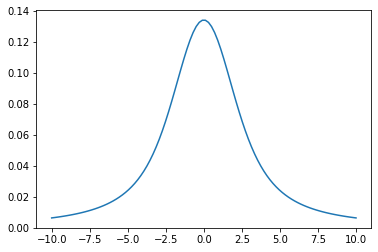

In [2]:
nu=jnp.linspace(-10,10,100)
plt.plot(nu, voigt(nu,1.0,2.0)) #beta=1.0, gamma_L=2.0

The function "voigt" is vmapped for nu (input=0), therefore a bit hard to handle when you want to differentiate. Instead, you can use "voigtone", which is not vmapped for all of the input arguments. 


In [3]:
from exojax.spec import voigtone 
from jax import grad, vmap

dvoigt_nu=vmap(grad(voigtone,argnums=0),(0,None,None),0) #derivative by nu
dvoigt_beta=vmap(grad(voigtone,argnums=1),(0,None,None),0) #derivative by beta

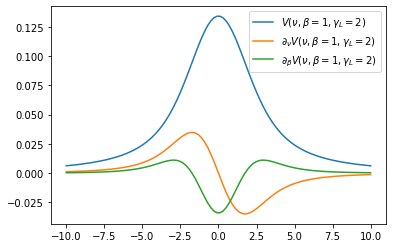

In [4]:
plt.plot(nu, voigt(nu,1.0,2.0),label="$V(\\nu,\\beta=1,\\gamma_L=2)$")
plt.plot(nu, dvoigt_nu(nu,1.0,2.0),label="$\\partial_\\nu V(\\nu,\\beta=1,\\gamma_L=2)$")
plt.plot(nu, dvoigt_beta(nu,1.0,2.0),label="$\\partial_\\beta V(\\nu,\\beta=1,\\gamma_L=2)$")
plt.legend()

## HMC-NUTS of a simple absorption model

Next, we try to fit a simple absorption model to mock data.
The absorption model is 

$ 1 - e^{-a V(\nu,\beta,\gamma_L)}$


In [35]:
def absmodel(nu,a,beta,gamma_L):
    return 1.0 - jnp.exp(a*voigt(nu,beta,gamma_L))

Adding a noise...


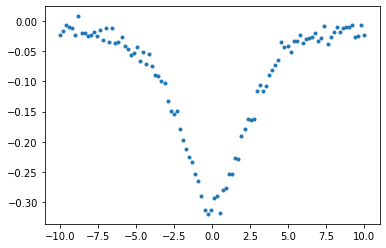

In [6]:
from numpy.random import normal
data=absmodel(nu,2.0,1.0,2.0)+normal(0.0,0.01,len(nu))
plt.plot(nu,data,".")

Then, let's perfomr a HMC-NUTS.

In [46]:
import arviz
import numpyro.distributions as dist
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

In [79]:
def model_c(nu,y):
    sigma = numpyro.sample('sigma', dist.Exponential(1.0))
    a = numpyro.sample('a', dist.Exponential(1.0))
    beta = numpyro.sample('beta', dist.Exponential(1.0))
    gamma_L = numpyro.sample('gammaL', dist.Exponential(1.0))
    mu=absmodel(nu,a,beta,gamma_L)
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [80]:
from jax import random
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000

In [81]:
kernel = NUTS(model_c,forward_mode_differentiation=True)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, nu=nu, y=data)

sample: 100%|██████████| 3000/3000 [00:33<00:00, 90.50it/s, 15 steps of size 1.69e-01. acc. prob=0.95] 


In [82]:

posterior_sample = mcmc.get_samples()
pred = Predictive(model_c,posterior_sample)
predictions = pred(rng_key_,nu=nu,y=None)
                                                                                    
median_mu = jnp.median(predictions["y"],axis=0)
hpdi_mu = hpdi(predictions["y"], 0.9)

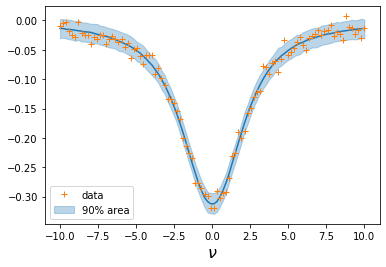

In [83]:
fig, ax = plt.subplots(nrows=1, ncols=1)                                                 
ax.plot(nu,median_mu,color="C0")
ax.plot(nu,data,"+",color="C1",label="data")
ax.fill_between(nu, hpdi_mu[0], hpdi_mu[1], alpha=0.3, interpolate=True,color="C0",
                label="90% area")
plt.xlabel("$\\nu$",fontsize=16)
plt.legend()


We got a posterior sampling.

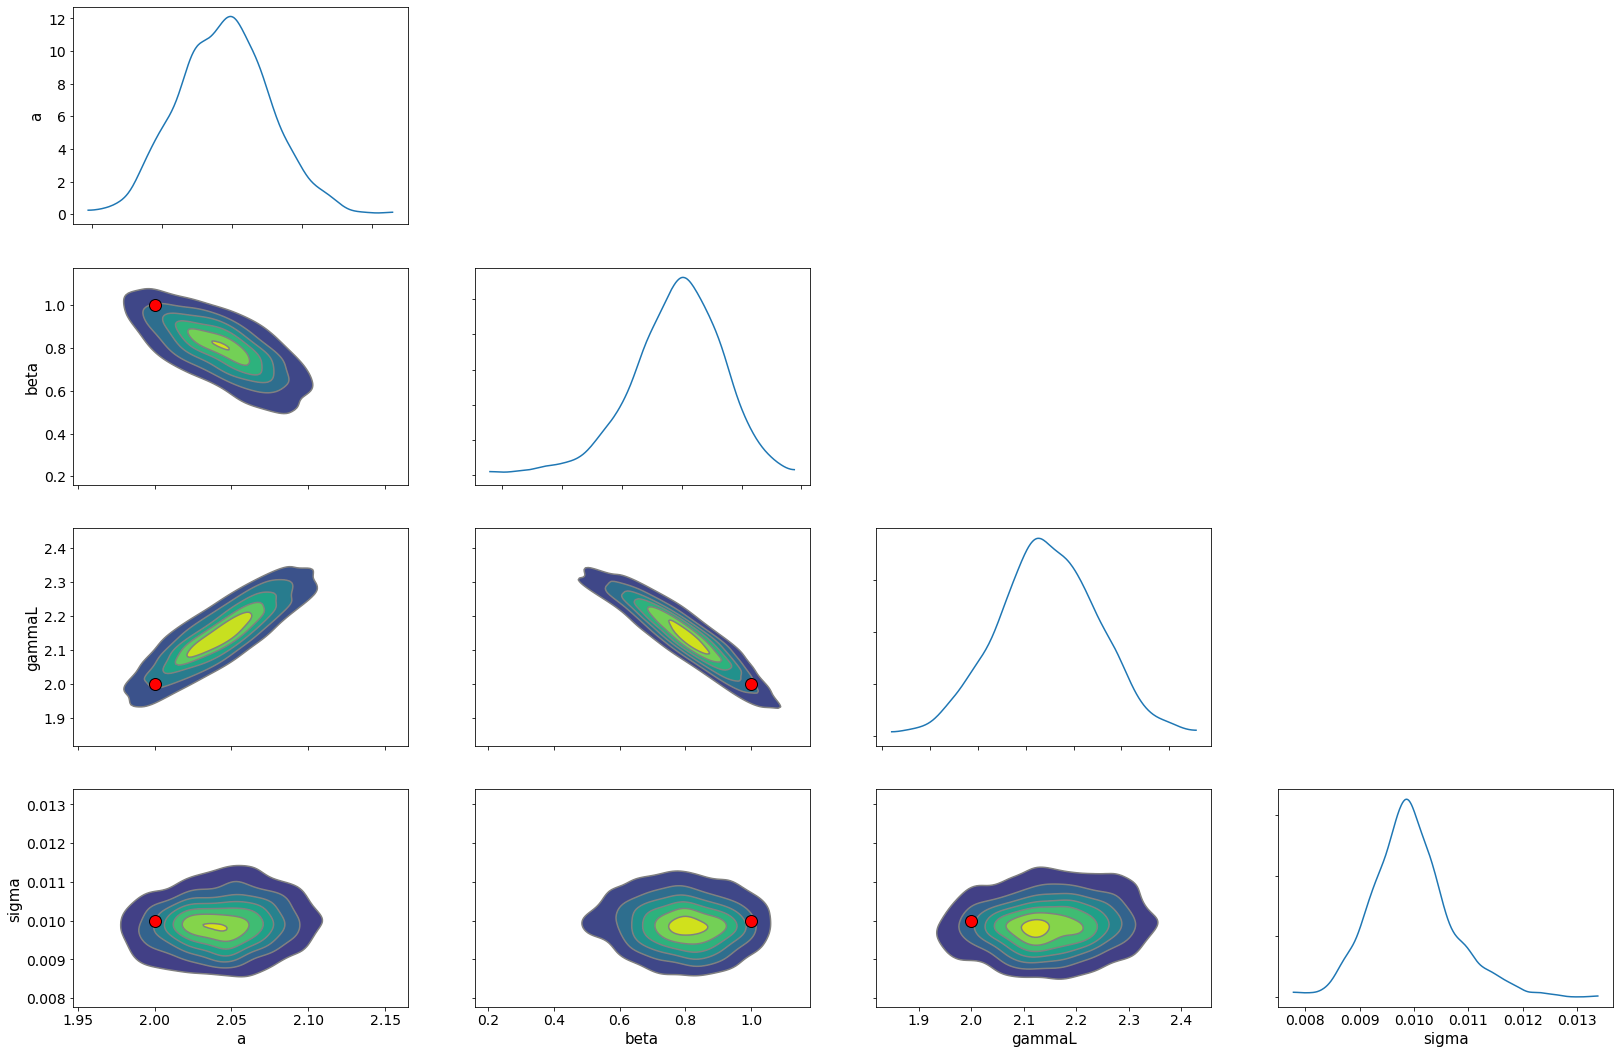

In [84]:
refs={};refs["sigma"]=0.01;refs["a"]=2.0;refs["beta"]=1.0;refs["gammaL"]=2.0
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',\
                divergences=False,marginals=True,reference_values=refs,\
               reference_values_kwargs={'color':"red", "marker":"o", "markersize":12})
plt.show()